In [84]:
%matplotlib inline
import pandas as pd
import os
import json
import cobra
import medusa
import task_utilities as task_utils

In [58]:
# Load data necessary to load the models
model_dir = '../data/reconstructions/'
model_dict = {}
reaction_diff_dict = {}
for fname in os.listdir(model_dir):
    species = fname.split('_')[0]
    if fname.find('reaction_diff') > 0:
        with open(model_dir+fname,'r') as jsonfile:
            reaction_diff_dict[species] = json.load(jsonfile)
        print("loaded reaction diff from " + fname)
    elif fname.startswith('ASF'):
        model = cobra.io.load_json_model(model_dir+fname)
        model_dict[species] = model
        print("loaded ensemble base model from " + fname)

loaded ensemble base model from ASF519_base_model.json
loaded reaction diff from ASF361_base_model_reaction_diffs.json
loaded ensemble base model from ASF356_base_model.json
loaded ensemble base model from ASF361_base_model.json
loaded reaction diff from ASF519_base_model_reaction_diffs.json
loaded reaction diff from ASF356_base_model_reaction_diffs.json


In [59]:
ensemble_dict = {}
for species in model_dict.keys():
    ensemble = medusa.Ensemble(base_id=species)
    ensemble.base_model = model_dict[species]
    # load only the first 100 reaction diffs to get 100 models
    to_keep = [species+'_'+str(i) for i in range(1,101)]
    ensemble.reaction_diffs = {single_model:reaction_diff_dict[species][single_model] for single_model in to_keep}
    ensemble_dict[species] = ensemble

In [60]:
# laod the media condition
# load universal model (needed to set media)
universal = cobra.io.load_json_model('../data/reconstructions/seed_universal.json')
# create a media dictionary for setting model bounds
mLB_dict = task_utils.create_media_dict('../data/reconstructions/ammended_media.csv', universal, estimated_uptake=True)


In [100]:
# for each model, set the media condition, set biomass as objective, then simulate growth and save values
mLB_growth = {}
for species in ensemble_dict.keys():
    task_utils.set_media(ensemble_dict[species].base_model,mLB_dict)
    ensemble_dict[species].base_model.objective = 'bio1'
    growth = ensemble_dict[species].optimize_ensemble(return_flux=['bio1'])
    mLB_growth[species] = {key:growth[key]['bio1'] for key in growth.keys()}

In [101]:
# supplment media with putative cross-fed metabolites to see if it improves growth
# For 356, supplement valine, choline, isoleucine, proline, formate, and alanine
mets_356 = {'valine':'cpd00156','choline':'cpd00098','isoleucine':'cpd00322',\
            'proline':'cpd00129','formate':'cpd00047','alanine':'cpd00035','tyramine':'cpd00374'}
# Glutamate and adenine were not consumed by 356 in monoculture, but were produced by 519 and 
# less abundant than anticipated in coculture
# for 361, supplement Proline, Fumarate, UMP, Hypoxanthine, Lactate, and AMP
mets_361 = {'proline':'cpd00129','fumarate':'cpd00106'}
# For 519, supplement ump, hypoxanthine, lactate, and amp (from 361 co-culture) and ump, 
# butyrate, isobutyrate, isocaproate, amp, inosine, isovalerate, and hypoxanthine (from 356 co-culture)
# isocaproate is not in modelSEED

mets_519 = {'ump':'cpd00091','hypoxanthine':'cpd00226',\
            'lactate':'cpd00159','amp':'cpd00018','butyrate':'cpd00094',\
           'isobutyrate':'cpd01711','amp':'cpd00018','inosine':'cpd00246','isovalerate':'cpd05178'}
not_supplemented_356 ={}
supplemented_356 = {}
not_supplemented_361 ={}
supplemented_361 = {}
not_supplemented_519 ={}
supplemented_519 = {}
for met in mets_356.keys():
    # knock out the metabolite and get the growth rate
    # check for exchange in model first
    ex_rxns = [rxn.id for rxn in ensemble_dict['ASF356'].base_model.reactions]
    if 'EX_'+mets_356[met]+'_e' in ex_rxns:
        old_bound = ensemble_dict['ASF356'].base_model.reactions.get_by_id('EX_'+mets_356[met]+'_e').lower_bound
        ensemble_dict['ASF356'].base_model.reactions.get_by_id('EX_'+mets_356[met]+'_e').lower_bound = 0
        wout_supplement = ensemble_dict['ASF356'].optimize_ensemble(return_flux=['bio1'])
        not_supplemented_356[met] = {key:wout_supplement[key]['bio1'] for key in wout_supplement.keys()}

        # supplement the compound and see to what extent growth increases
        ensemble_dict['ASF356'].base_model.reactions.get_by_id('EX_'+mets_356[met]+'_e').lower_bound = -100
        w_supplement = ensemble_dict['ASF356'].optimize_ensemble(return_flux=['bio1'])
        supplemented_356[met] = {key:w_supplement[key]['bio1'] for key in w_supplement.keys()}

        # reset the bounds to the original bounds
        ensemble_dict['ASF356'].base_model.reactions.get_by_id('EX_'+mets_356[met]+'_e').lower_bound = old_bound
    
for met in mets_361.keys():
    # knock out the metabolite and get the growth rate
    ex_rxns = [rxn.id for rxn in ensemble_dict['ASF361'].base_model.reactions]
    if 'EX_'+mets_361[met]+'_e' in ex_rxns:
        old_bound = ensemble_dict['ASF361'].base_model.reactions.get_by_id('EX_'+mets_361[met]+'_e').lower_bound
        ensemble_dict['ASF361'].base_model.reactions.get_by_id('EX_'+mets_361[met]+'_e').lower_bound = 0
        wout_supplement = ensemble_dict['ASF361'].optimize_ensemble(return_flux=['bio1'])
        not_supplemented_361[met] = {key:wout_supplement[key]['bio1'] for key in wout_supplement.keys()}

        # supplement the compound and see to what extent growth increases
        ensemble_dict['ASF361'].base_model.reactions.get_by_id('EX_'+mets_361[met]+'_e').lower_bound = -100
        w_supplement = ensemble_dict['ASF361'].optimize_ensemble(return_flux=['bio1'])
        supplemented_361[met] = {key:w_supplement[key]['bio1'] for key in w_supplement.keys()}

        # reset the bounds to the original bounds
        ensemble_dict['ASF361'].base_model.reactions.get_by_id('EX_'+mets_361[met]+'_e').lower_bound = old_bound
    
for met in mets_519.keys():
    # knock out the metabolite and get the growth rate
    ex_rxns = [rxn.id for rxn in ensemble_dict['ASF519'].base_model.reactions]
    if 'EX_'+mets_519[met]+'_e' in ex_rxns:
        old_bound = ensemble_dict['ASF519'].base_model.reactions.get_by_id('EX_'+mets_519[met]+'_e').lower_bound
        ensemble_dict['ASF519'].base_model.reactions.get_by_id('EX_'+mets_519[met]+'_e').lower_bound = 0
        wout_supplement = ensemble_dict['ASF519'].optimize_ensemble(return_flux=['bio1'])
        not_supplemented_519[met] = {key:wout_supplement[key]['bio1'] for key in wout_supplement.keys()}

        # supplement the compound and see to what extent growth increases
        ensemble_dict['ASF519'].base_model.reactions.get_by_id('EX_'+mets_519[met]+'_e').lower_bound = -100
        w_supplement = ensemble_dict['ASF519'].optimize_ensemble(return_flux=['bio1'])
        supplemented_519[met] = {key:w_supplement[key]['bio1'] for key in w_supplement.keys()}

        # reset the bounds to the original bounds
        ensemble_dict['ASF519'].base_model.reactions.get_by_id('EX_'+mets_519[met]+'_e').lower_bound = old_bound

In [124]:
# For each metabolite, we need the mean growth rate with it removed, present in excess, and the number of 
# GENREs for which the metabolite was esssential
table_356 = {}
for met in supplemented_356.keys():
    print(met)
    table_356[met] = {}
    table_356[met]['mean with metabolite'] = pd.DataFrame.from_dict(supplemented_356[met],orient='index').mean()[0]
    table_356[met]['mean without metabolite'] = pd.DataFrame.from_dict(not_supplemented_356[met],orient='index').mean()[0]
    table_356[met]['Fraction essential'] = str((pd.DataFrame.from_dict(not_supplemented_356[met],orient='index') < 0.00001).sum()[0])+'/100'
    print(pd.DataFrame.from_dict(supplemented_356[met],orient='index').mean()[0],\
          pd.DataFrame.from_dict(supplemented_356[met],orient='index').std()[0])
          
    print(pd.DataFrame.from_dict(not_supplemented_356[met],orient='index').mean()[0],\
         pd.DataFrame.from_dict(not_supplemented_356[met],orient='index').std()[0])

valine
0.169079952205 0.00884640034279
3.40330436777e-17 0.0
proline
0.169079952205 0.00884640034279
0.169079707248 0.00884473873964
isoleucine
0.169079952205 0.00884640034279
0.02503736465 0.0599382825954
formate
0.169079952205 0.00884640034279
0.169079952205 0.00884640034279
alanine
0.169079952205 0.00884640034279
0.168996711473 0.0088587826141
choline
0.169079952205 0.00884640034279
0.169079952205 0.00884640034279


In [125]:
pd.DataFrame(table_356)

,alanine,choline,formate,isoleucine,proline,valine
Fraction essential,0/100,0/100,0/100,85/100,0/100,100/100
mean with metabolite,0.16908,0.16908,0.16908,0.16908,0.16908,0.16908
mean without metabolite,0.168997,0.16908,0.16908,0.0250374,0.16908,3.4033e-17


In [126]:
table_361 = {}
for met in supplemented_361.keys():
    print(met)
    table_361[met] = {}
    table_361[met]['mean with metabolite'] = pd.DataFrame.from_dict(supplemented_361[met],orient='index').mean()[0]
    table_361[met]['mean without metabolite'] = pd.DataFrame.from_dict(not_supplemented_361[met],orient='index').mean()[0]
    table_361[met]['Fraction essential'] = str((pd.DataFrame.from_dict(not_supplemented_361[met],orient='index') < 0.00001).sum()[0])+'/100'
    print(pd.DataFrame.from_dict(supplemented_361[met],orient='index').mean()[0],\
          pd.DataFrame.from_dict(supplemented_361[met],orient='index').std()[0])
          
    print(pd.DataFrame.from_dict(not_supplemented_361[met],orient='index').mean()[0],\
         pd.DataFrame.from_dict(not_supplemented_361[met],orient='index').std()[0])

proline
0.878717538283 0.105476138133
0.878557632385 0.10558390048
fumarate
0.892625797017 0.0510486792266
0.72104540429 0.354332197565


In [127]:
pd.DataFrame(table_361)

,fumarate,proline
Fraction essential,19/100,0/100
mean with metabolite,0.892626,0.878718
mean without metabolite,0.721045,0.878558


In [128]:
table_519 = {}
for met in supplemented_519.keys():
    print(met)
    table_519[met] = {}
    table_519[met]['mean with metabolite'] = pd.DataFrame.from_dict(supplemented_519[met],orient='index').mean()[0]
    table_519[met]['mean without metabolite'] = pd.DataFrame.from_dict(not_supplemented_519[met],orient='index').mean()[0]
    table_519[met]['Fraction essential'] = str((pd.DataFrame.from_dict(not_supplemented_519[met],orient='index') < 0.00001).sum()[0])+'/100'
    print(pd.DataFrame.from_dict(supplemented_519[met],orient='index').mean()[0],\
          pd.DataFrame.from_dict(supplemented_519[met],orient='index').std()[0])
          
    print(pd.DataFrame.from_dict(not_supplemented_519[met],orient='index').mean()[0],\
         pd.DataFrame.from_dict(not_supplemented_519[met],orient='index').std()[0])

lactate
4.38092807494 0.67782431765
4.38092807494 0.67782431765
amp
4.38092807494 0.67782431765
4.38092807494 0.67782431765
hypoxanthine
4.41912566755 0.753113350152
4.15639997693 0.34367096472
inosine
4.41912566755 0.753113350152
4.15639997693 0.34367096472
ump
4.38092807494 0.67782431765
4.38092807494 0.67782431765


In [129]:
pd.DataFrame(table_519)

,amp,hypoxanthine,inosine,lactate,ump
Fraction essential,0/100,0/100,0/100,0/100,0/100
mean with metabolite,4.38093,4.41913,4.41913,4.38093,4.38093
mean without metabolite,4.38093,4.1564,4.1564,4.38093,4.38093


0    3.403304e-17
dtype: float64

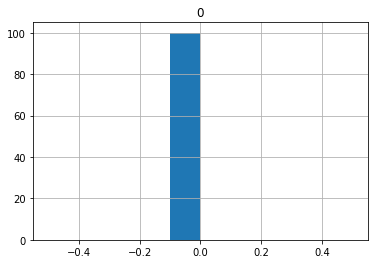

In [106]:
pd.DataFrame.from_dict(not_supplemented_356['valine'],orient='index').hist()
pd.DataFrame.from_dict(not_supplemented_356['valine'],orient='index').max()

0    15
dtype: int64

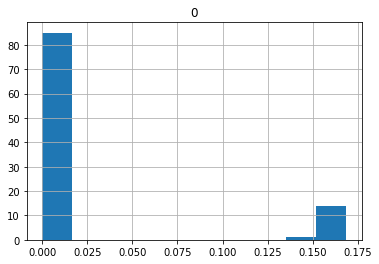

In [112]:
pd.DataFrame.from_dict(not_supplemented_356['isoleucine'],orient='index').hist()
pd.DataFrame.from_dict(not_supplemented_356['isoleucine'],orient='index').max()
(pd.DataFrame.from_dict(not_supplemented_356['isoleucine'],orient='index') > 0.00001).sum()

0    0.228501
dtype: float64

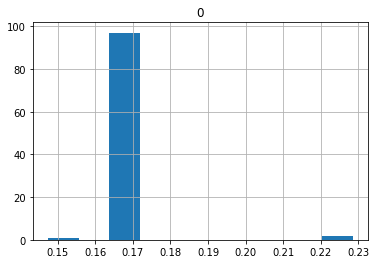

In [107]:
pd.DataFrame.from_dict(supplemented_356['valine'],orient='index').hist()
pd.DataFrame.from_dict(supplemented_356['valine'],orient='index').max()

In [ ]:
# Perform FVA on the exchange reactions to get

In [93]:
ensemble_dict['ASF356'].base_model.metabolites.get_by_id('cpd00374_c')

KeyError: 'cpd00374_c'